Saving Lab Session Data.xlsx to Lab Session Data (1).xlsx

Train Metrics:
MSE: 331228846.41761696
RMSE: 18199.693580322088
MAPE: 0.23789177709521866
R2: 0.5044922278517608

Test Metrics:
MSE: 111487445.87814885
RMSE: 10558.761569338938
MAPE: 0.21074740233167566
R2: 0.7740265253816192

========== K-Means Clustering ==========
Cluster Centers:
[[-0.14082263 -0.71379996 -0.16276833  0.02840417  0.8917261   0.76354061
   0.90105308  0.78264021  0.77046415  0.64012023 -0.17240335  0.6247533
   0.95057477  0.85372546 -0.68550861  0.04944769  0.2420952   0.45353995
   0.38032069  0.18456929 -0.038689    0.          0.          0.27069398]
 [ 0.08916603  0.45196366  0.1030616  -0.01798494 -0.56462288 -0.48345843
  -0.57052854 -0.49555191 -0.48784228 -0.40531115  0.10916231 -0.39558112
  -0.60188467 -0.54056165  0.43405016 -0.03130927 -0.15328977 -0.2871723
  -0.24081135 -0.11686553  0.02449709  0.          0.         -0.17139794]]

========== Clustering Scores ==========
Silhouette Score: 0.26

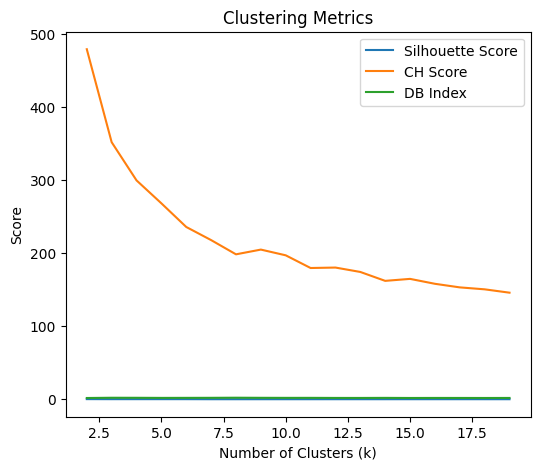

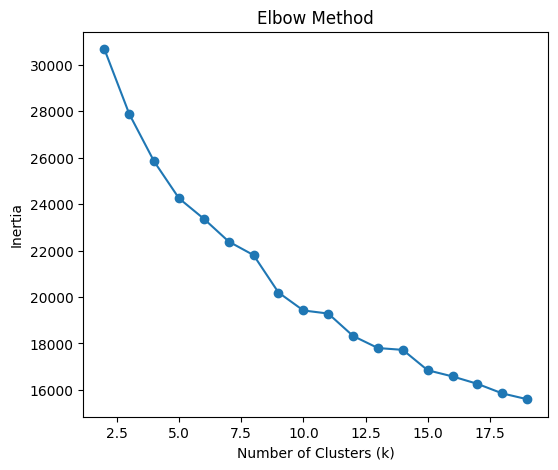

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Upload file
uploaded = files.upload()
filePath = list(uploaded.keys())[0]

def loadData(filePath, sheetName):
    return pd.read_excel(BytesIO(uploaded[filePath]), sheet_name=sheetName)

df = loadData(filePath, 'marketing_campaign')

# Preprocess Data
def preprocessData(df, target):
    df = df.select_dtypes(include=[np.number])
    df.drop(columns=["ID"], inplace=True, errors='ignore')
    df.dropna(inplace=True)
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

X, y = preprocessData(df, "Income")

# Split Data
def splitData(X, y, testSize=0.2, randomState=42):
    return train_test_split(X, y, test_size=testSize, random_state=randomState)

XTrain, XTest, yTrain, yTest = splitData(X, y)

# Standardize Features
def standardizeData(XTrain, XTest):
    scaler = StandardScaler()
    return scaler.fit_transform(XTrain), scaler.transform(XTest)

XTrainScaled, XTestScaled = standardizeData(XTrain, XTest)

# Train Regression Model
def trainModel(XTrainScaled, yTrain):
    model = LinearRegression()
    model.fit(XTrainScaled, yTrain)
    return model

model = trainModel(XTrainScaled, yTrain)

def predict(model, XTrainScaled, XTestScaled):
    return model.predict(XTrainScaled), model.predict(XTestScaled)

yTrainPred, yTestPred = predict(model, XTrainScaled, XTestScaled)

# Compute Regression Metrics
def regressionMetrics(yTrue, yPred):
    mse = mean_squared_error(yTrue, yPred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(yTrue, yPred)
    r2 = r2_score(yTrue, yPred)
    return mse, rmse, mape, r2

trainMetrics = regressionMetrics(yTrain, yTrainPred)
testMetrics = regressionMetrics(yTest, yTestPred)

def printMetrics(metrics, label):
    print(f"\n{label} Metrics:")
    print(f"MSE: {metrics[0]}")
    print(f"RMSE: {metrics[1]}")
    print(f"MAPE: {metrics[2]}")
    print(f"R2: {metrics[3]}")

printMetrics(trainMetrics, "Train")
printMetrics(testMetrics, "Test")

# K-Means Clustering
def kMeansClustering(XTrainScaled, clusters=2):
    return KMeans(n_clusters=clusters, random_state=0, n_init='auto').fit(XTrainScaled)

kmeans = kMeansClustering(XTrainScaled)

def printClusterCenters(kmeans):
    print("\n========== K-Means Clustering ==========")
    print("Cluster Centers:")
    print(kmeans.cluster_centers_)

printClusterCenters(kmeans)

def clusteringScores(XTrainScaled, labels):
    return silhouette_score(XTrainScaled, labels), calinski_harabasz_score(XTrainScaled, labels), davies_bouldin_score(XTrainScaled, labels)

silhouette, chScore, dbIndex = clusteringScores(XTrainScaled, kmeans.labels_)

def printClusteringScores(silhouette, chScore, dbIndex):
    print("\n========== Clustering Scores ==========")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Score: {chScore:.4f}")
    print(f"Davies-Bouldin Index: {dbIndex:.4f}")

printClusteringScores(silhouette, chScore, dbIndex)

def evaluateClustering(XTrainScaled, kValues):
    silhouetteScores, chScores, dbScores, distortions = [], [], [], []
    for k in kValues:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(XTrainScaled)
        silhouetteScores.append(silhouette_score(XTrainScaled, kmeans.labels_))
        chScores.append(calinski_harabasz_score(XTrainScaled, kmeans.labels_))
        dbScores.append(davies_bouldin_score(XTrainScaled, kmeans.labels_))
        distortions.append(kmeans.inertia_)
    return silhouetteScores, chScores, dbScores, distortions

kValues = range(2, 20)
silhouetteScores, chScores, dbScores, distortions = evaluateClustering(XTrainScaled, kValues)

def plotMetrics(kValues, silhouetteScores, chScores, dbScores):
    plt.figure(figsize=(6, 5))
    plt.plot(kValues, silhouetteScores, label="Silhouette Score")
    plt.plot(kValues, chScores, label="CH Score")
    plt.plot(kValues, dbScores, label="DB Index")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Clustering Metrics")
    plt.show()

def plotElbowMethod(kValues, distortions):
    plt.figure(figsize=(6, 5))
    plt.plot(kValues, distortions, marker="o")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method")
    plt.show()

plotMetrics(kValues, silhouetteScores, chScores, dbScores)
plotElbowMethod(kValues, distortions)